In [0]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
# The GPU id to use, usually either "0" or "1";
# os.environ["CUDA_VISIBLE_DEVICES"]="0";  

import tensorflow as tf
import keras
from keras.layers import Dense, Flatten
from keras.layers import MaxPooling2D, Dropout, Conv2D, Activation
import numpy as np
import numpy.random as random
import pylab as plt
from keras.datasets import mnist, cifar10
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from sklearn import svm
import time
from datetime import datetime
import matplotlib

Using TensorFlow backend.


# Cifar

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

DIM = 32*32*3

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

y_train = y_train.flatten()
y_test = y_test.flatten()

x_tr_animals = x_train[(y_train==2) | (y_train==3) | (y_train==5) | (y_train==7)]
x_tr_non_animals = x_train[(y_train==0) | (y_train==1) | (y_train==8) | (y_train==9)]

x_te_animals = x_test[(y_test==2) | (y_test==3) | (y_test==5) | (y_test==7)]
x_te_non_animals = x_test[(y_test==0) | (y_test==1) | (y_test==8) | (y_test==9)]

def getXY(x_anim, x_nonanim):  # setup labels, and return the dataset (x, y), randomly perputed
    data = np.concatenate((x_anim, x_nonanim))
    data = data.astype('float32')
    data /= 255.
    labels = np.concatenate((np.zeros(len(x_anim)), np.ones(len(x_nonanim))))
    I = np.random.permutation(len(data))
    x = data[I]
    y = labels[I]
    return x, y

x_train, y_train = getXY(x_tr_animals, x_tr_non_animals)
x_test, y_test = getXY(x_te_animals, x_te_non_animals)

x_train shape: (50000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)


# MNIST

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

DIM = 28*28*3

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

y_train = y_train.flatten()
y_test = y_test.flatten()

x_tr_animals = x_train[y_train<5]
x_tr_non_animals = x_train[y_train>=5]

x_te_animals = x_test[y_test<5]
x_te_non_animals = x_test[y_test>=5]

def getXY(x_anim, x_nonanim):  # setup labels, and return the dataset (x, y), randomly perputed
    data = np.concatenate((x_anim, x_nonanim))
    data = data.astype('float32')
    data /= 255.
    labels = np.concatenate((np.zeros(len(x_anim)), np.ones(len(x_nonanim))))
    I = np.random.permutation(len(data))
    x = data[I]
    y = labels[I]
    return x, y

x_train, y_train = getXY(x_tr_animals, x_tr_non_animals)
x_test, y_test = getXY(x_te_animals, x_te_non_animals)

11493376/11490434 [==============================] - 1s 0us/step
x_train shape: (60000, 28, 28)
x_test shape: (10000, 28, 28)


In [0]:
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

# Info

In [0]:
def get_random_FNN(W, hidden_layers, input_dim=DIM):
    model = keras.Sequential()
    model.add(Flatten())
    w = input_dim
    for i in range(hidden_layers):
        model.add(Dense(W, activation='relu',input_shape=[w],
                        kernel_initializer=keras.initializers.random_normal(stddev = 1.0/np.sqrt(w)),
                        bias_initializer=keras.initializers.random_normal(stddev = 1.0/np.sqrt(W))))
        w = W

    model.add(Dense(1, activation='sigmoid',input_shape=[w],
                  kernel_initializer=keras.initializers.random_normal(stddev = 1.0/np.sqrt(w)),
                  bias_initializer='zeros'))


    return model


def get_random_cifar_CNN(lr=0.001):
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(32, kernel_size=(3, 3),
                   activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(keras.layers.Dense(2000, activation='relu'))
    model.add(keras.layers.Dense(2000, activation='relu'))
    #model.add(Dropout(0.5))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    sgd = keras.optimizers.SGD(lr=lr)
    model.compile(optimizer=sgd, 
              loss='binary_crossentropy', metrics=['accuracy'])

    return model
  


##
## Information Computations
##

# estimate I(M(x); y | L(x))
def estimate_IMYL(model, linModel, x, y):
    p = est_density(model, linModel, x, y)
    return I_XYZ(p)

def est_density_MYL(model, linModel, x, y):
    Mx = np.round(model.predict(x)).flatten()
    Lx = np.round(linModel.predict(x)).flatten()
    y = y.flatten()
    
    p = est_density(Mx, y, Lx)
    return p
    
def est_density(X, Y, Z): # estimate p[x,y,z] \in R^{{0,1}^3} for samples from X, Y, Z \in \N
    X = X.astype(int)
    Y = Y.astype(int)
    Z = Z.astype(int)
    
    n = len(X)
    p = np.zeros((2, 2, 2)) # p[x,y,z] is the joint prob density
    for i in range(n):
        p[X[i], Y[i], Z[i]] += 1.0
    p /= n
    return p

def I_XYZ(p): # compute I(X, Y | Z) for joint density p[x, y, z]
    pz = np.sum(p, axis=(0,1), keepdims=True) # the density of z. pz[x,y,z] = p(z)
    
    p_xy_z = p / pz  # q[x, y, z] = p(x, y | z)
    p_x_z =  np.sum(p, axis=1, keepdims=True) / pz  # p(x | z)
    p_y_z =  np.sum(p, axis=0, keepdims=True) / pz  # p(y | z)
    
    I = np.sum(p * np.nan_to_num(np.log2( p_xy_z / (p_x_z * p_y_z) )))
    return I


# returns I(A; B) where A, B \in {X, Y, Z} spefice by idx
# eg, I(X; Y) = I_ab(p, idx=[0, 1])
#     I(X; Z) = I_ab(p, idx=[0, 2])
def I_ab(p, idx=(0,1)): 
    exlude = (0+1+2) - np.sum(idx)
    p_ab = np.sum(p, axis=exlude)
    p_a = np.sum(p_ab, axis=1, keepdims=True)
    p_b = np.sum(p_ab, axis=0, keepdims=True)
    
    I = np.sum(p_ab * np.nan_to_num(np.log2( p_ab / (p_a * p_b) )))
    return I

def H(q): # binary entropy
    return -q*np.log2(q) - (1-q)*np.log2(1-q)


# Cifar experiment

In [0]:
# find optimal linear classifier for CIFAR
lin = get_random_FNN(W = 0, hidden_layers=0, input_dim = DIM)
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) 
lin.compile(optimizer=sgd,loss='binary_crossentropy', metrics=['accuracy'])
lin.fit(x_train, y_train, batch_size=128, epochs=100, verbose=True, validation_data=(x_test, y_test))

In [0]:
times = 5
epochs = 300


model_acc = np.zeros((times, epochs))
I_MYL = np.zeros((times, epochs))
# I_ML = np.zeros((times, epochs))
I_MY = np.zeros((times, epochs))
I_MY_train = np.zeros((times, epochs))

# num_of_batches = 10
# batch_size = int(len(x_train) / num_of_batches)
for t in range(times):
  model = get_random_cifar_CNN(lr=0.001)
  print("time number ", t)

  for ep in range(epochs):
      print("Starting epoch at time: ", str(datetime.now().time()))
      #learnt, r_acc = train_linear(model, epochs=30, verbose=False)
      #repro_acc.append(r_acc)

      pMYL = est_density_MYL(model, lin, x_test, y_test)  # p[M, Y, L]
      I_MYL[t, ep] = I_XYZ(pMYL)
      I_MY[t, ep] = I_ab(pMYL, idx=(0, 1))
      
      pMYL_train = est_density_MYL(model, lin, x_train, y_train)  # p[M, Y, L]
      I_MY_train[t, ep] = I_ab(pMYL_train, idx=(0, 1))
      
      model_loss, m_acc = model.evaluate(x_test, y_test)
      model_acc[t, ep] = m_acc
      model.fit(x_train, y_train, batch_size=64, epochs=1, verbose=True)

      print("DONE WITH EPOCH: ", ep)
      print("\n")

gap = I_MY - I_MYL
_, lin_acc = lin.evaluate(x_test, y_test)

plt.rcParams["font.family"] = 'serif'

eps = epochs
fig, ax1 = plt.subplots()
# ax1.plot(range(eps), gap.mean(axis=0), label='I(Model(x); Y) - I(Model(x); Y | Lin(x))')
ax1.plot(range(eps), gap.mean(axis=0), label='I(F$_t$; Y) - I(F$_t$; Y | Lin)')
ax1.fill_between(range(eps), gap.mean(axis=0)-gap.std(axis=0), gap.mean(axis=0)+gap.std(axis=0), alpha=0.2)
# ax1.plot(range(eps), I_MY.mean(axis=0), label='I(Model(x); Y)')
ax1.plot(range(eps), I_MY.mean(axis=0), label='I(F$_t$; Y)')
ax1.fill_between(range(eps), I_MY.mean(axis=0)-I_MY.std(axis=0), I_MY.mean(axis=0)+I_MY.std(axis=0), alpha=0.2)

ax1.plot(range(eps), I_MY_train.mean(axis=0), label='I(F$_t$; Y$_S$)')
ax1.fill_between(range(eps), I_MY_train.mean(axis=0)-I_MY_train.std(axis=0), I_MY_train.mean(axis=0)+I_MY_train.std(axis=0), alpha=0.2)


# ax1.plot(range(eps), I_LYM.mean(axis=0), label='I(Lin(x); Y | Model(x))')
# ax1.plot(range(eps), I_LYM.mean(axis=0), label='I(L(x); Y | M(x))')
# ax1.fill_between(range(eps), I_LYM.mean(axis=0)-I_LYM.std(axis=0), I_LYM.mean(axis=0)+I_LYM.std(axis=0), alpha=0.3)

ax1.plot(range(eps), (1-H(lin_acc))*np.ones(eps), linestyle='--', linewidth=1, label='Best Linear')

plt.xlabel("SGD epochs")
plt.ylabel("Mutual Information")
# plt.grid(True, axis='y')

ax1.legend()
ax1.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = ax1.twinx()
ax2.plot(ax1.get_ylim(), alpha=0)
ax2.set_ylabel("Accuracy")
ax2.set_ylim(ax1.get_ylim())

# l = ax1.get_ylim()
# l2 = ax2.get_ylim()
labels = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 0.99])
# f = lambda x : l2[0]+(x-l[0])/(l[1]-l[0])*(l2[1]-l2[0])
# ticks = f(1-H(labels))
ax2.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(1-H(labels)))
ax2.set_yticklabels(labels)
plt.title('CIFAR10, Animals vs Objects - Mutual-Information')

labels = np.linspace(0.5, 1, 6)



# ax2.set_yticks(ytx2)
fig.tight_layout()

time number  0
Starting epoch at time:  22:49:36.441651
8000/8000 [==============================] - 1s 74us/step
Epoch 1/1
40000/40000 [==============================] - 4s 102us/step - loss: 0.6928 - acc: 0.5030
DONE WITH EPOCH:  0


Starting epoch at time:  22:49:47.623436
8000/8000 [==============================] - 1s 76us/step
Epoch 1/1
40000/40000 [==============================] - 4s 101us/step - loss: 0.6917 - acc: 0.5033
DONE WITH EPOCH:  1


Starting epoch at time:  22:49:56.612185
8000/8000 [==============================] - 1s 70us/step
Epoch 1/1
40000/40000 [==============================] - 4s 95us/step - loss: 0.6905 - acc: 0.5114
DONE WITH EPOCH:  2


Starting epoch at time:  22:50:05.599106
8000/8000 [==============================] - 1s 79us/step
Epoch 1/1
40000/40000 [==============================] - 4s 99us/step - loss: 0.6890 - acc: 0.5269
DONE WITH EPOCH:  3


Starting epoch at time:  22:50:14.610824
8000/8000 [==============================] - 1s 69us/step
Epoc

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in log2


8000/8000 [==============================] - 1s 69us/step
Epoch 1/1
40000/40000 [==============================] - 4s 96us/step - loss: 0.6898 - acc: 0.5077
DONE WITH EPOCH:  1


Starting epoch at time:  23:32:46.874518
8000/8000 [==============================] - 1s 77us/step
Epoch 1/1
40000/40000 [==============================] - 4s 97us/step - loss: 0.6866 - acc: 0.5314
DONE WITH EPOCH:  2


Starting epoch at time:  23:32:56.062772
8000/8000 [==============================] - 1s 68us/step
Epoch 1/1
40000/40000 [==============================] - 4s 91us/step - loss: 0.6820 - acc: 0.5735
DONE WITH EPOCH:  3


Starting epoch at time:  23:33:04.434362
8000/8000 [==============================] - 1s 70us/step
Epoch 1/1
40000/40000 [==============================] - 4s 92us/step - loss: 0.6750 - acc: 0.6260
DONE WITH EPOCH:  4


Starting epoch at time:  23:33:12.852505
8000/8000 [==============================] - 1s 69us/step
Epoch 1/1
40000/40000 [==============================] - 4s 92

In [0]:
times = 4
epochs = 300


model_acc = np.zeros((times, epochs))
I_MYL = np.zeros((times, epochs))
# I_ML = np.zeros((times, epochs))
I_MY = np.zeros((times, epochs))
I_MY_train = np.zeros((times, epochs))

# num_of_batches = 10
# batch_size = int(len(x_train) / num_of_batches)
for t in range(times):
  model = get_random_cifar_CNN_gal(lr=0.001)
  print("time number ", t)

  for ep in range(epochs):
      print("Starting epoch at time: ", str(datetime.now().time()))
      #learnt, r_acc = train_linear(model, epochs=30, verbose=False)
      #repro_acc.append(r_acc)

      pMYL = est_density_MYL(model, lin, x_test, y_test)  # p[M, Y, L]
      I_MYL[t, ep] = I_XYZ(pMYL)
      I_MY[t, ep] = I_ab(pMYL, idx=(0, 1))
      
      pMYL_train = est_density_MYL(model, lin, x_train, y_train)  # p[M, Y, L]
      I_MY_train[t, ep] = I_ab(pMYL_train, idx=(0, 1))
      
      model_loss, m_acc = model.evaluate(x_test, y_test)
      model_acc[t, ep] = m_acc
      model.fit(x_train, y_train, batch_size=64, epochs=1, verbose=True)

      print("DONE WITH EPOCH: ", ep)
      print("\n")

gap = I_MY - I_MYL
_, lin_acc = lin.evaluate(x_test, y_test)

plt.rcParams["font.family"] = 'serif'

eps = epochs
fig, ax1 = plt.subplots()
# ax1.plot(range(eps), gap.mean(axis=0), label='I(Model(x); Y) - I(Model(x); Y | Lin(x))')
ax1.plot(range(eps), gap.mean(axis=0), label='I(F$_t$; Y) - I(F$_t$; Y | Lin)')
ax1.fill_between(range(eps), gap.mean(axis=0)-gap.std(axis=0), gap.mean(axis=0)+gap.std(axis=0), alpha=0.2)
# ax1.plot(range(eps), I_MY.mean(axis=0), label='I(Model(x); Y)')
ax1.plot(range(eps), I_MY.mean(axis=0), label='I(F$_t$; Y)')
ax1.fill_between(range(eps), I_MY.mean(axis=0)-I_MY.std(axis=0), I_MY.mean(axis=0)+I_MY.std(axis=0), alpha=0.2)

ax1.plot(range(eps), I_MY_train.mean(axis=0), label='I(F$_t$; Y$_S$)')
ax1.fill_between(range(eps), I_MY_train.mean(axis=0)-I_MY_train.std(axis=0), I_MY_train.mean(axis=0)+I_MY_train.std(axis=0), alpha=0.2)


# ax1.plot(range(eps), I_LYM.mean(axis=0), label='I(Lin(x); Y | Model(x))')
# ax1.plot(range(eps), I_LYM.mean(axis=0), label='I(L(x); Y | M(x))')
# ax1.fill_between(range(eps), I_LYM.mean(axis=0)-I_LYM.std(axis=0), I_LYM.mean(axis=0)+I_LYM.std(axis=0), alpha=0.3)

ax1.plot(range(eps), (1-H(lin_acc))*np.ones(eps), linestyle='--', linewidth=1, label='Best Linear')

plt.xlabel("SGD epochs")
plt.ylabel("Mutual Information")
# plt.grid(True, axis='y')

ax1.legend()
ax1.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = ax1.twinx()
ax2.plot(ax1.get_ylim(), alpha=0)
ax2.set_ylabel("Accuracy")
ax2.set_ylim(ax1.get_ylim())

# l = ax1.get_ylim()
# l2 = ax2.get_ylim()
labels = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 0.99])
# f = lambda x : l2[0]+(x-l[0])/(l[1]-l[0])*(l2[1]-l2[0])
# ticks = f(1-H(labels))
ax2.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(1-H(labels)))
ax2.set_yticklabels(labels)
plt.title('CIFAR10, Animals vs Objects - Mutual-Information')

labels = np.linspace(0.5, 1, 6)



# ax2.set_yticks(ytx2)
fig.tight_layout()

time number  0
Starting epoch at time:  19:23:41.634713


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:146: RuntimeWarning: invalid value encountered in true_divide


8000/8000 [==============================] - 1s 85us/step
Epoch 1/1
40000/40000 [==============================] - 5s 117us/step - loss: 0.6926 - acc: 0.4989
DONE WITH EPOCH:  0


Starting epoch at time:  19:23:52.345513


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:146: RuntimeWarning: divide by zero encountered in log2


8000/8000 [==============================] - 1s 76us/step
Epoch 1/1
40000/40000 [==============================] - 4s 106us/step - loss: 0.6905 - acc: 0.5005
DONE WITH EPOCH:  1


Starting epoch at time:  19:24:01.737967
8000/8000 [==============================] - 1s 75us/step
Epoch 1/1
40000/40000 [==============================] - 4s 107us/step - loss: 0.6881 - acc: 0.5060
DONE WITH EPOCH:  2


Starting epoch at time:  19:24:11.027182
8000/8000 [==============================] - 1s 77us/step
Epoch 1/1
40000/40000 [==============================] - 4s 109us/step - loss: 0.6850 - acc: 0.5166
DONE WITH EPOCH:  3


Starting epoch at time:  19:24:20.387763
8000/8000 [==============================] - 1s 86us/step
Epoch 1/1
40000/40000 [==============================] - 5s 117us/step - loss: 0.6806 - acc: 0.5457
DONE WITH EPOCH:  4


Starting epoch at time:  19:24:30.836428
8000/8000 [==============================] - 1s 76us/step
Epoch 1/1
40000/40000 [==============================] - 4

8000/8000 [==============================] - 0s 57us/step


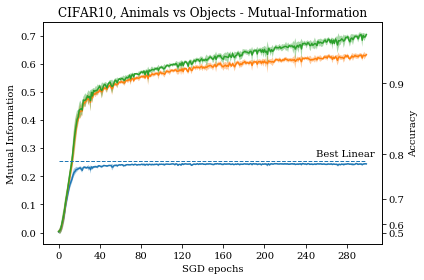

In [0]:
plt.rcParams["font.family"] = 'serif'
eps = epochs

gap = I_MY - I_MYL
_, lin_acc = lin.evaluate(x_test, y_test)

fig, ax1 = plt.subplots()
# ax1.plot(range(eps), gap.mean(axis=0), label='I(Model(x); Y) - I(Model(x); Y | Lin(x))')
ax1.plot(range(eps), gap.mean(axis=0), label='I(F$_t$; Y) - I(F$_t$; Y | Lin)')
ax1.fill_between(range(eps), gap.mean(axis=0)-gap.std(axis=0), gap.mean(axis=0)+gap.std(axis=0), alpha=0.4)
# ax1.plot(range(eps), I_MY.mean(axis=0), label='I(Model(x); Y)')
ax1.plot(range(eps), I_MY.mean(axis=0), label='I(F$_t$; Y)')
ax1.fill_between(range(eps), I_MY.mean(axis=0)-I_MY.std(axis=0), I_MY.mean(axis=0)+I_MY.std(axis=0), alpha=0.4)

ax1.plot(range(eps), I_MY_train.mean(axis=0), label='I(F$_t$; Y$_S$)')
ax1.fill_between(range(eps), I_MY_train.mean(axis=0)-I_MY_train.std(axis=0), I_MY_train.mean(axis=0)+I_MY_train.std(axis=0), alpha=0.4)


# ax1.plot(range(eps), I_LYM.mean(axis=0), label='I(Lin(x); Y | Model(x))')
# ax1.plot(range(eps), I_LYM.mean(axis=0), label='I(L(x); Y | M(x))')
# ax1.fill_between(range(eps), I_LYM.mean(axis=0)-I_LYM.std(axis=0), I_LYM.mean(axis=0)+I_LYM.std(axis=0), alpha=0.3)

ax1.plot(range(eps), (1-H(lin_acc))*np.ones(eps), linestyle='--', linewidth=1, label='Best Linear', color='C0')

plt.text(range(eps)[-50],  (1-H(lin_acc))+0.015, 'Best Linear')

plt.xlabel("SGD epochs")
plt.ylabel("Mutual Information")
# plt.grid(True, axis='y')

# ax1.legend()
ax1.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = ax1.twinx()
ax2.plot(ax1.get_ylim(), alpha=0)
ax2.set_ylabel("Accuracy")
ax2.set_ylim(ax1.get_ylim())

# l = ax1.get_ylim()
# l2 = ax2.get_ylim()
labels = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 0.99])
# f = lambda x : l2[0]+(x-l[0])/(l[1]-l[0])*(l2[1]-l2[0])
# ticks = f(1-H(labels))
ax2.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(1-H(labels)))
ax2.set_yticklabels(labels)
plt.title('CIFAR10, Animals vs Objects - Mutual-Information')

labels = np.linspace(0.5, 1, 6)



# ax2.set_yticks(ytx2)
fig.tight_layout()

plt.sa

In [0]:
gap.tofile('mu.npy')
((1-H(lin_acc))*np.ones(eps)).tofile('best_lin.npy')
I_MY.tofile("I_MY.npy")
I_MY_train.tofile("I_MY_train.npy")

In [0]:
((1-H(lin_acc))*np.ones(eps))

array([0.25589721, 0.25589721, 0.25589721, 0.25589721, 0.25589721,
       0.25589721, 0.25589721, 0.25589721, 0.25589721, 0.25589721,
       0.25589721, 0.25589721, 0.25589721, 0.25589721, 0.25589721,
       0.25589721, 0.25589721, 0.25589721, 0.25589721, 0.25589721,
       0.25589721, 0.25589721, 0.25589721, 0.25589721, 0.25589721,
       0.25589721, 0.25589721, 0.25589721, 0.25589721, 0.25589721,
       0.25589721, 0.25589721, 0.25589721, 0.25589721, 0.25589721,
       0.25589721, 0.25589721, 0.25589721, 0.25589721, 0.25589721,
       0.25589721, 0.25589721, 0.25589721, 0.25589721, 0.25589721,
       0.25589721, 0.25589721, 0.25589721, 0.25589721, 0.25589721,
       0.25589721, 0.25589721, 0.25589721, 0.25589721, 0.25589721,
       0.25589721, 0.25589721, 0.25589721, 0.25589721, 0.25589721,
       0.25589721, 0.25589721, 0.25589721, 0.25589721, 0.25589721,
       0.25589721, 0.25589721, 0.25589721, 0.25589721, 0.25589721,
       0.25589721, 0.25589721, 0.25589721, 0.25589721, 0.25589

# MNIST

In [0]:
lin = get_random_FNN(W = 0, hidden_layers=0, input_dim = DIM)
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) 
lin.compile(optimizer=sgd,loss='binary_crossentropy', metrics=['accuracy'])
lin.fit(x_train, y_train, batch_size=128, epochs=100, verbose=True, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 1s 25us/step - loss: 0.4238 - acc: 0.8185 - val_loss: 0.3699 - val_acc: 0.8484
Epoch 2/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.3790 - acc: 0.8436 - val_loss: 0.3569 - val_acc: 0.8571
Epoch 3/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.3684 - acc: 0.8482 - val_loss: 0.3501 - val_acc: 0.8607
Epoch 4/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.3619 - acc: 0.8528 - val_loss: 0.3453 - val_acc: 0.8641
Epoch 5/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.3572 - acc: 0.8562 - val_loss: 0.3416 - val_acc: 0.8630
Epoch 6/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.3536 - acc: 0.8576 - val_loss: 0.3393 - val_acc: 0.8666
Epoch 7/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.3508 - acc: 0.8597 - val_loss: 0.3372 - 

In [0]:
times = 10
epochs = 50


model_acc = np.zeros((times, epochs))
I_MYL = np.zeros((times, epochs))
# I_ML = np.zeros((times, epochs))
I_MY = np.zeros((times, epochs))
I_MY_train = np.zeros((times, epochs))

# num_of_batches = 10
# batch_size = int(len(x_train) / num_of_batches)
for t in range(times):
  model = get_random_cifar_CNN(lr=0.001)
  print("time number ", t)

  for ep in range(epochs):
      print("Starting epoch at time: ", str(datetime.now().time()))
      #learnt, r_acc = train_linear(model, epochs=30, verbose=False)
      #repro_acc.append(r_acc)

      pMYL = est_density_MYL(model, lin, x_test, y_test)  # p[M, Y, L]
      I_MYL[t, ep] = I_XYZ(pMYL)
      I_MY[t, ep] = I_ab(pMYL, idx=(0, 1))
      
      pMYL_train = est_density_MYL(model, lin, x_train, y_train)  # p[M, Y, L]
      I_MY_train[t, ep] = I_ab(pMYL_train, idx=(0, 1))
      
      model_loss, m_acc = model.evaluate(x_test, y_test)
      model_acc[t, ep] = m_acc
      model.fit(x_train, y_train, batch_size=64, epochs=1, verbose=True)

      print("DONE WITH EPOCH: ", ep)
      print("\n")

gap = I_MY - I_MYL
_, lin_acc = lin.evaluate(x_test, y_test)

plt.rcParams["font.family"] = 'serif'

eps = epochs
fig, ax1 = plt.subplots()
# ax1.plot(range(eps), gap.mean(axis=0), label='I(Model(x); Y) - I(Model(x); Y | Lin(x))')
ax1.plot(range(eps), gap.mean(axis=0), label='I(F$_t$; Y) - I(F$_t$; Y | Lin)')
ax1.fill_between(range(eps), gap.mean(axis=0)-gap.std(axis=0), gap.mean(axis=0)+gap.std(axis=0), alpha=0.2)
# ax1.plot(range(eps), I_MY.mean(axis=0), label='I(Model(x); Y)')
ax1.plot(range(eps), I_MY.mean(axis=0), label='I(F$_t$; Y)')
ax1.fill_between(range(eps), I_MY.mean(axis=0)-I_MY.std(axis=0), I_MY.mean(axis=0)+I_MY.std(axis=0), alpha=0.2)

ax1.plot(range(eps), I_MY_train.mean(axis=0), label='I(F$_t$; Y$_S$)')
ax1.fill_between(range(eps), I_MY_train.mean(axis=0)-I_MY_train.std(axis=0), I_MY_train.mean(axis=0)+I_MY_train.std(axis=0), alpha=0.2)


# ax1.plot(range(eps), I_LYM.mean(axis=0), label='I(Lin(x); Y | Model(x))')
# ax1.plot(range(eps), I_LYM.mean(axis=0), label='I(L(x); Y | M(x))')
# ax1.fill_between(range(eps), I_LYM.mean(axis=0)-I_LYM.std(axis=0), I_LYM.mean(axis=0)+I_LYM.std(axis=0), alpha=0.3)

ax1.plot(range(eps), (1-H(lin_acc))*np.ones(eps), linestyle='--', linewidth=1, label='Best Linear')

plt.xlabel("SGD epochs")
plt.ylabel("Mutual Information")
# plt.grid(True, axis='y')

ax1.legend()
ax1.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = ax1.twinx()
ax2.plot(ax1.get_ylim(), alpha=0)
ax2.set_ylabel("Accuracy")
ax2.set_ylim(ax1.get_ylim())

# l = ax1.get_ylim()
# l2 = ax2.get_ylim()
labels = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 0.99])
# f = lambda x : l2[0]+(x-l[0])/(l[1]-l[0])*(l2[1]-l2[0])
# ticks = f(1-H(labels))
ax2.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(1-H(labels)))
ax2.set_yticklabels(labels)
plt.title('Mnist, 0-4 vs 5-9 - Mutual-Information')

labels = np.linspace(0.5, 1, 6)



# ax2.set_yticks(ytx2)
fig.tight_layout()

10000/10000 [==============================] - 0s 41us/step


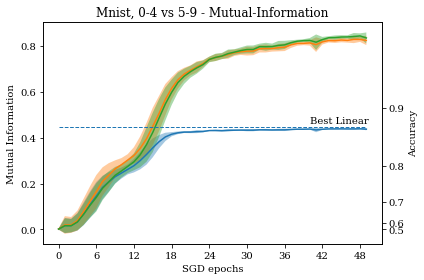

In [0]:
plt.rcParams["font.family"] = 'serif'
eps = epochs

gap = I_MY - I_MYL
_, lin_acc = lin.evaluate(x_test, y_test)

fig, ax1 = plt.subplots()
# ax1.plot(range(eps), gap.mean(axis=0), label='I(Model(x); Y) - I(Model(x); Y | Lin(x))')
ax1.plot(range(eps), gap.mean(axis=0), label='I(F$_t$; Y) - I(F$_t$; Y | Lin)')
ax1.fill_between(range(eps), gap.mean(axis=0)-gap.std(axis=0), gap.mean(axis=0)+gap.std(axis=0), alpha=0.4)
# ax1.plot(range(eps), I_MY.mean(axis=0), label='I(Model(x); Y)')
ax1.plot(range(eps), I_MY.mean(axis=0), label='I(F$_t$; Y)')
ax1.fill_between(range(eps), I_MY.mean(axis=0)-I_MY.std(axis=0), I_MY.mean(axis=0)+I_MY.std(axis=0), alpha=0.4)

ax1.plot(range(eps), I_MY_train.mean(axis=0), label='I(F$_t$; Y$_S$)')
ax1.fill_between(range(eps), I_MY_train.mean(axis=0)-I_MY_train.std(axis=0), I_MY_train.mean(axis=0)+I_MY_train.std(axis=0), alpha=0.4)


# ax1.plot(range(eps), I_LYM.mean(axis=0), label='I(Lin(x); Y | Model(x))')
# ax1.plot(range(eps), I_LYM.mean(axis=0), label='I(L(x); Y | M(x))')
# ax1.fill_between(range(eps), I_LYM.mean(axis=0)-I_LYM.std(axis=0), I_LYM.mean(axis=0)+I_LYM.std(axis=0), alpha=0.3)

ax1.plot(range(eps), (1-H(lin_acc))*np.ones(eps), linestyle='--', linewidth=1, label='Best Linear', color='C0')

plt.text(range(eps)[-10],  (1-H(lin_acc))+0.015, 'Best Linear')

# ax1.plot(range(eps), (1-H(lin_acc))*np.ones(eps), linestyle='--', linewidth=1, label='Best Linear', color='C0')

# plt.text(range(eps)[-50],  (1-H(lin_acc))+0.015, 'Best Linear'

plt.xlabel("SGD epochs")
plt.ylabel("Mutual Information")
# plt.grid(True, axis='y')

# ax1.legend()
ax1.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = ax1.twinx()
ax2.plot(ax1.get_ylim(), alpha=0)
ax2.set_ylabel("Accuracy")
ax2.set_ylim(ax1.get_ylim())

# l = ax1.get_ylim()
# l2 = ax2.get_ylim()
labels = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 0.99])
# f = lambda x : l2[0]+(x-l[0])/(l[1]-l[0])*(l2[1]-l2[0])
# ticks = f(1-H(labels))
ax2.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(1-H(labels)))
ax2.set_yticklabels(labels)
plt.title('Mnist, 0-4 vs 5-9 - Mutual-Information')

labels = np.linspace(0.5, 1, 6)



# ax2.set_yticks(ytx2)
fig.tight_layout()

In [0]:
gap.tofile('mu.npy')
((1-H(lin_acc))*np.ones(eps)).tofile('best_lin.npy')
I_MY.tofile("I_MY.npy")
I_MY_train.tofile("I_MY_train.npy")

time number  0
Starting epoch at time:  23:08:32.625518
10000/10000 [==============================] - 1s 52us/step
Epoch 1/1
60000/60000 [==============================] - 5s 81us/step - loss: 0.6927 - acc: 0.5095
DONE WITH EPOCH:  0


Starting epoch at time:  23:08:44.010828


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:146: RuntimeWarning: invalid value encountered in true_divide


10000/10000 [==============================] - 1s 51us/step
Epoch 1/1
60000/60000 [==============================] - 5s 75us/step - loss: 0.6919 - acc: 0.5099
DONE WITH EPOCH:  1


Starting epoch at time:  23:08:52.913139
10000/10000 [==============================] - 1s 60us/step
Epoch 1/1
60000/60000 [==============================] - 5s 84us/step - loss: 0.6911 - acc: 0.5099
DONE WITH EPOCH:  2


Starting epoch at time:  23:09:03.334109
10000/10000 [==============================] - 1s 52us/step
Epoch 1/1
60000/60000 [==============================] - 5s 75us/step - loss: 0.6903 - acc: 0.5099
DONE WITH EPOCH:  3


Starting epoch at time:  23:09:12.287833
10000/10000 [==============================] - 0s 49us/step
Epoch 1/1
60000/60000 [==============================] - 5s 75us/step - loss: 0.6893 - acc: 0.5101
DONE WITH EPOCH:  4


Starting epoch at time:  23:09:21.200680


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:146: RuntimeWarning: divide by zero encountered in log2


10000/10000 [==============================] - 1s 52us/step
Epoch 1/1
60000/60000 [==============================] - 5s 82us/step - loss: 0.6879 - acc: 0.5166
DONE WITH EPOCH:  5


Starting epoch at time:  23:09:30.583028
10000/10000 [==============================] - 1s 56us/step
Epoch 1/1
60000/60000 [==============================] - 5s 75us/step - loss: 0.6862 - acc: 0.5597
DONE WITH EPOCH:  6


Starting epoch at time:  23:09:39.958461
10000/10000 [==============================] - 0s 49us/step
Epoch 1/1
60000/60000 [==============================] - 4s 75us/step - loss: 0.6837 - acc: 0.6134
DONE WITH EPOCH:  7


Starting epoch at time:  23:09:48.840331
10000/10000 [==============================] - 1s 52us/step
Epoch 1/1
60000/60000 [==============================] - 4s 75us/step - loss: 0.6802 - acc: 0.6833
DONE WITH EPOCH:  8


Starting epoch at time:  23:09:57.724483
10000/10000 [==============================] - 1s 50us/step
Epoch 1/1
60000/60000 [=============================

NameError: ignored

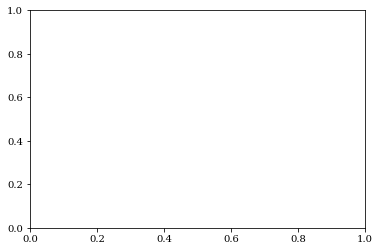

In [0]:
times = 10
epochs = 50


model_acc = np.zeros((times, epochs))
I_MYL = np.zeros((times, epochs))
# I_ML = np.zeros((times, epochs))
I_MY = np.zeros((times, epochs))
I_MY_train = np.zeros((times, epochs))

# num_of_batches = 10
# batch_size = int(len(x_train) / num_of_batches)
for t in range(times):
  model = get_random_cifar_CNN_gal(lr=0.001)
  print("time number ", t)

  for ep in range(epochs):
      print("Starting epoch at time: ", str(datetime.now().time()))
      #learnt, r_acc = train_linear(model, epochs=30, verbose=False)
      #repro_acc.append(r_acc)

      pMYL = est_density_MYL(model, lin, x_test, y_test)  # p[M, Y, L]
      I_MYL[t, ep] = I_XYZ(pMYL)
      I_MY[t, ep] = I_ab(pMYL, idx=(0, 1))
      
      pMYL_train = est_density_MYL(model, lin, x_train, y_train)  # p[M, Y, L]
      I_MY_train[t, ep] = I_ab(pMYL_train, idx=(0, 1))
      
      model_loss, m_acc = model.evaluate(x_test, y_test)
      model_acc[t, ep] = m_acc
      model.fit(x_train, y_train, batch_size=64, epochs=1, verbose=True)

      print("DONE WITH EPOCH: ", ep)
      print("\n")

eps = epochs
gap = I_MY - I_MYL
_, lin_acc = lin.evaluate(x_test, y_test)

plt.rcParams["font.family"] = 'serif'


gap = I_MY - I_MYL
_, lin_acc = lin.evaluate(x_test, y_test)

fig, ax1 = plt.subplots()
# ax1.plot(range(eps), gap.mean(axis=0), label='I(Model(x); Y) - I(Model(x); Y | Lin(x))')
ax1.plot(range(eps), gap.mean(axis=0), label='I(F$_t$; Y) - I(F$_t$; Y | Lin)')
ax1.fill_between(range(eps), gap.mean(axis=0)-gap.std(axis=0), gap.mean(axis=0)+gap.std(axis=0), alpha=0.2)
# ax1.plot(range(eps), I_MY.mean(axis=0), label='I(Model(x); Y)')
ax1.plot(range(eps), I_MY.mean(axis=0), label='I(F$_t$; Y)')
ax1.fill_between(range(eps), I_MY.mean(axis=0)-I_MY.std(axis=0), I_MY.mean(axis=0)+I_MY.std(axis=0), alpha=0.2)

ax1.plot(range(eps), I_MY_train.mean(axis=0), label='I(F$_t$; Y$_S$)')
ax1.fill_between(range(eps), I_MY_train.mean(axis=0)-I_MY_train.std(axis=0), I_MY_train.mean(axis=0)+I_MY_train.std(axis=0), alpha=0.2)


# ax1.plot(range(eps), I_LYM.mean(axis=0), label='I(Lin(x); Y | Model(x))')
# ax1.plot(range(eps), I_LYM.mean(axis=0), label='I(L(x); Y | M(x))')
# ax1.fill_between(range(eps), I_LYM.mean(axis=0)-I_LYM.std(axis=0), I_LYM.mean(axis=0)+I_LYM.std(axis=0), alpha=0.3)

ax1.plot(range(eps), (1-H(lin_acc))*np.ones(eps), linestyle='--', linewidth=1, label='Best Linear')

plt.xlabel("SGD epochs")
plt.ylabel("Mutual Information")
# plt.grid(True, axis='y')

ax1.legend()
ax1.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = ax1.twinx()
ax2.plot(ax1.get_ylim(), alpha=0)
ax2.set_ylabel("Accuracy")
ax2.set_ylim(ax1.get_ylim())

# l = ax1.get_ylim()
# l2 = ax2.get_ylim()
labels = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 0.99])
# f = lambda x : l2[0]+(x-l[0])/(l[1]-l[0])*(l2[1]-l2[0])
# ticks = f(1-H(labels))
ax2.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(1-H(labels)))
ax2.set_yticklabels(labels)
plt.title('Mnist, 0-4 vs 5-9 - Mutual-Information')

labels = np.linspace(0.5, 1, 6)



# ax2.set_yticks(ytx2)
fig.tight_layout()

10000/10000 [==============================] - 0s 39us/step


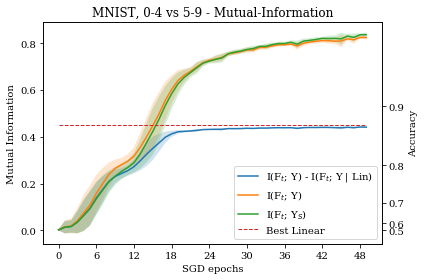

In [0]:
eps = epochs
gap = I_MY - I_MYL
_, lin_acc = lin.evaluate(x_test, y_test)

plt.rcParams["font.family"] = 'serif'


gap = I_MY - I_MYL
_, lin_acc = lin.evaluate(x_test, y_test)

fig, ax1 = plt.subplots()
# ax1.plot(range(eps), gap.mean(axis=0), label='I(Model(x); Y) - I(Model(x); Y | Lin(x))')
ax1.plot(range(eps), gap.mean(axis=0), label='I(F$_t$; Y) - I(F$_t$; Y | Lin)')
ax1.fill_between(range(eps), gap.mean(axis=0)-gap.std(axis=0), gap.mean(axis=0)+gap.std(axis=0), alpha=0.2)
# ax1.plot(range(eps), I_MY.mean(axis=0), label='I(Model(x); Y)')
ax1.plot(range(eps), I_MY.mean(axis=0), label='I(F$_t$; Y)')
ax1.fill_between(range(eps), I_MY.mean(axis=0)-I_MY.std(axis=0), I_MY.mean(axis=0)+I_MY.std(axis=0), alpha=0.2)

ax1.plot(range(eps), I_MY_train.mean(axis=0), label='I(F$_t$; Y$_S$)')
ax1.fill_between(range(eps), I_MY_train.mean(axis=0)-I_MY_train.std(axis=0), I_MY_train.mean(axis=0)+I_MY_train.std(axis=0), alpha=0.2)


# ax1.plot(range(eps), I_LYM.mean(axis=0), label='I(Lin(x); Y | Model(x))')
# ax1.plot(range(eps), I_LYM.mean(axis=0), label='I(L(x); Y | M(x))')
# ax1.fill_between(range(eps), I_LYM.mean(axis=0)-I_LYM.std(axis=0), I_LYM.mean(axis=0)+I_LYM.std(axis=0), alpha=0.3)

ax1.plot(range(eps), (1-H(lin_acc))*np.ones(eps), linestyle='--', linewidth=1, label='Best Linear')

plt.xlabel("SGD epochs")
plt.ylabel("Mutual Information")
# plt.grid(True, axis='y')

ax1.legend()
ax1.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = ax1.twinx()
ax2.plot(ax1.get_ylim(), alpha=0)
ax2.set_ylabel("Accuracy")
ax2.set_ylim(ax1.get_ylim())

# l = ax1.get_ylim()
# l2 = ax2.get_ylim()
labels = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 0.99])
# f = lambda x : l2[0]+(x-l[0])/(l[1]-l[0])*(l2[1]-l2[0])
# ticks = f(1-H(labels))
ax2.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(1-H(labels)))
ax2.set_yticklabels(labels)
plt.title('MNIST, 0-4 vs 5-9 - Mutual-Information')

labels = np.linspace(0.5, 1, 6)



# ax2.set_yticks(ytx2)
fig.tight_layout()

In [0]:
np.array(eps).tofile('mnist_eps.npy')
I_MYL.tofile('mnist_I_MYL.npy')
I_MY.tofile('mnist_I_MY.npy')
gap.tofile('mnist_gap.npy')

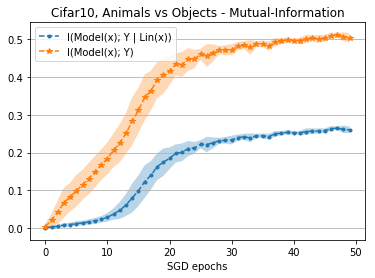

In [0]:
# eps = len(model_acc[0])
# plt.plot(range(eps), model_acc.mean(axis=0), label='model test accuracy')
# plt.legend()

plt.figure()
plt.grid(True, axis='y')
plt.title('Cifar10, Animals vs Objects - Mutual-Information')
plt.plot(range(eps), I_MYL.mean(axis=0), linestyle='--', marker='.', label='I(Model(x); Y | Lin(x))')
plt.fill_between(range(eps), I_MYL.mean(axis=0)-I_MYL.std(axis=0), I_MYL.mean(axis=0)+I_MYL.std(axis=0), alpha=0.3)
# plt.plot(range(eps), I_ML.mean(axis=0), label='I(Model(x); Lin(x))')
# plt.fill_between(range(eps), I_ML.mean(axis=0)-I_ML.std(axis=0), I_ML.mean(axis=0)+I_ML.std(axis=0), alpha=0.3)
plt.plot(range(eps), I_MY.mean(axis=0),  linestyle='--', marker='*',label='I(Model(x); Y)')
plt.fill_between(range(eps), I_MY.mean(axis=0)-I_MY.std(axis=0), I_MY.mean(axis=0)+I_MY.std(axis=0), alpha=0.3)
plt.xlabel("SGD epochs")
plt.legend()

In [0]:
x_test.shape

(9108, 28, 28)

In [0]:
np.array(eps).tofile('ana_eps.npy')
I_MYL.tofile('ana_I_MYL_rev.npy')
I_MY.tofile('ana_I_MY_rev.npy')
gap.tofile("ana_gap_rev.npy")

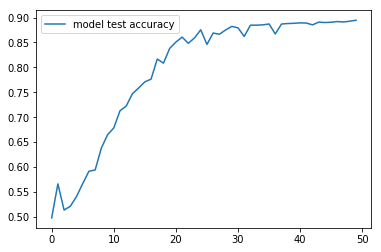

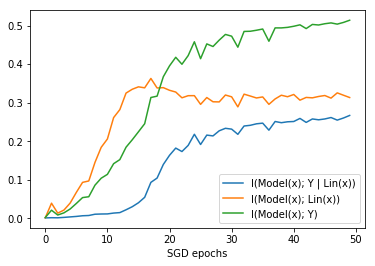

In [0]:
eps = len(model_acc)
plt.plot(range(eps), model_acc, label='model test accuracy')
plt.legend()

plt.figure()
plt.plot(range(eps), I_MYL, label='I(Model(x); Y | Lin(x))')
# plt.plot(range(eps), I_ML, label='I(Model(x); Lin(x))')
plt.plot(range(eps), I_MY, label='I(Model(x); Y)')
plt.xlabel("SGD epochs")
plt.legend()

In [0]:
lin_learner, r_acc = train_linear(model, epochs=30, verbose=True)

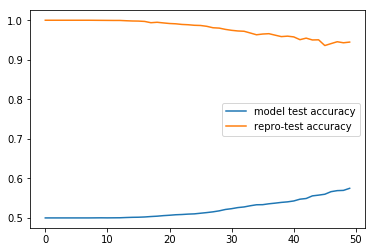

In [0]:
eps = len(repro_acc)
plt.plot(range(eps), model_acc, label='model test accuracy')
plt.plot(range(eps), repro_acc, label='repro-test accuracy')
plt.legend()

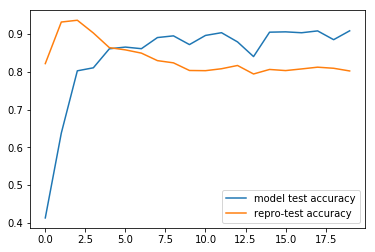